# **DESARROLLO DE MEDICAMENTOS EMPLEANDO INTELIGENCIA ARTIFICIAL**

 GRADO EN INGENIERÍA DE LA SALUD - *Trabajo Fin de Grado* 

Realizado por: *Beatriz García Dueñas* 

Tutor: *Juan Antonio Nepomuceno Chamorro*

Departamento: Lenguajes y Sistemas Informáticos


# **CASO DE ESTUDIO 1**

El primer caso de estudio tiene como objetivo crear un modelo generativo capaz de crear nuevas moléculas a partir de un conjunto de muestras de entrada.

Entrenaremos una red MolGAN (red generativa adversarial)[5] la cual consta de las siguientes partes:
- Un generador: toma una muestra z de una distribución normal para generar un grafo.
- Un discriminador: recibe los grafos del generador como entrada y produce una salida. 
- Una red de recompensa: se emplea para obtener un aprendizaje por refuerzo que nos proporcionará la capacidad de generar moléculas con propiedades químicas deseadas.

Tanto para la salida del discriminador como para la salida de la red de recompensa se emplean redes convolucionales de grafos (Graph Convolutional Networks)

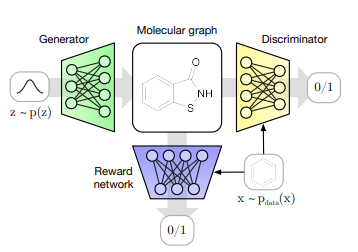
 *Esquema de una red MolGAN*

En primer lugar, comenzaremos instalando la librería principal que emplearemos, DeepChem, e importando los paquetes que necesitaremos durante el desarrollo de este caso de estudio.

In [3]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 693 kB 7.4 MB/s 
     |████████████████████████████████| 29.5 MB 1.2 MB/s 


'2.6.2.dev'

In [18]:
import deepchem as dc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
from collections import OrderedDict

import deepchem.models
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
from tensorflow import one_hot
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

Como conjunto de muestras de entrada, trabajaremos con tox21, un dataset importado de MoleculeNet que cuenta con 7831 compuestos químicos. Además, crearemos un data frame con las cadenas SMILES de las muestras. 

In [19]:
tasks, datasets, transformers = dc.molnet.load_tox21()
dataframe = pd.DataFrame(data={'smiles': datasets[0].ids}) #Emplearemos el primer conjunto de datos de tox21


In [20]:
data=dataframe
dataframe


,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6259,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6260,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6261,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6262,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


A continuación, especificaremos el número máximo de átomos a codificar para el clasificador y la red MolGAN. Cuánto mayor sea este número, más moléculas se incluirán y, por tanto, el conjunto global de datos será mayor, lo que hará que también aumente la complejidad del modelo. Escogeremos un número de 12 átomos máximo por molécula. 



Hay que tener en cuenta que moléculas demasiado pequeñas (menos de una decena de átomos) no generarán suficiente energía de interacción. En cambio, moléculas grandes (con más de 40 átomos) es probable que no puedan ser solubles en agua y, por tanto, no podrán emplearse como futuros fármacos.


In [21]:
num_atoms = 12




Una vez contamos con el conjunto de datos de entrada, iniciaremos el caracterizador (featurizer, en inglés) que emplearemos posteriormente para caracterizar las muestras. La función que emplearemos es .feat.MolGanFeaturizer, perteneciente a la librería DeepChem. Lo inicializamos con las variables num_atoms, el número máximo de átomos por molécula fijado anteriormente y otra variable denominada atom_labels.


El parámetro atom_labels representa el número atómico de los átomos que queremos incluir para el análisis. Cada átomo de la tabla periódica tiene un número atómico Z, el cual representa el número de protones que contiene ese átomo. Pasándole una lista del número átomico a nuestra función, estaremos incluyendo únicamente aquellas moléculas que contengan esos átomos con ese número atómico.  Como pasa con la restricción de número máximo de átomos, cuánto más átomos incluyamos, más complejo será nuestro modelo.

Probaremos en nuestro caso de estudio con los siguientes átomos y sus correspondientes números atómicos. Siempre se puede ampliar añadiendo el número atómico de aquellos átomos que queramos incluir.

0: Neutronio; 5:Boro; 6:Carbono; 7:Nitrógeno; 8: Oxígeno; 9: Flúor; 11: Sodio; 12: Magensio; 13: Aluminio; 14:Silicio.


In [22]:
feat = dc.feat.MolGanFeaturizer(max_atom_count=num_atoms, atom_labels=[0, 5, 6, 7, 8, 9, 11, 12, 13, 14]) #15, 16, 17, 19, 20, 24, 29, 35, 53, 80])

Extraemos las cadenas SMILES del data frame y las introducimos en una lista


In [23]:
smiles = data['smiles'].values

Filtramos las moléculas cuyo número de átomos sea superior a 12, la variable que hemos fijado anteriormente.

In [24]:
filtered_smiles = [x for x in smiles if Chem.MolFromSmiles(x).GetNumAtoms() < num_atoms]

En el siguiente paso, emplearemos el “caracterizador” que hemos llamado antes “feat” y lo aplicaremos a las cadenas SMILES anteriormente filtradas. La representación por defecto de las moléculas caracterizadas será en forma de objeto “GraphMatrix”.

In [25]:
features = feat.featurize(filtered_smiles)

/usr/local/lib/python3.7/dist-packages/deepchem/feat/base_classes.py:323: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)


Con el siguiente bucle, eliminaremos las moléculas no válidas para nuestro conjunto de entrenamiento, aquellas que no sean un objeto de tipo GraphMatrix. Con ello, evitaremos errores posteriores. Nos quedaremos con los índices de aquellas moléculas que si representen un objeto GraphMatrix y actualizaremos la variable (“features”.) de las muestras con las que contamos para nuestro modelo. 


In [26]:
indices = [ i for i, data in enumerate(features) if type(data) is GraphMatrix ]
print(indices)
features = [features[i] for i in indices]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 34, 35, 36, 37, 38, 43, 46, 47, 48, 50, 51, 52, 53, 56, 58, 59, 60, 62, 63, 64, 65, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 83, 84, 85, 86, 88, 89, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 109, 110, 111, 112, 113, 114, 115, 119, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 137, 138, 139, 140, 143, 144, 145, 149, 150, 157, 159, 164, 165, 169, 170, 171, 172, 173, 174, 176, 177, 179, 181, 182, 184, 186, 188, 189, 191, 192, 196, 197, 198, 199, 202, 205, 206, 207, 208, 209, 213, 215, 216, 219, 220, 221, 222, 225, 226, 227, 229, 231, 232, 233, 234, 235, 236, 237, 239, 240, 244, 247, 248, 249, 252, 254, 255, 256, 257, 258, 261, 262, 264, 265, 266, 268, 269, 270, 273, 274, 275, 277, 278, 280, 283, 285, 286, 287, 288, 289, 292, 296, 297, 298, 299, 300, 301, 302, 303, 304, 306, 307, 308, 309, 312, 313, 314, 315, 317, 318, 319, 320, 321, 324, 325, 326, 327, 328, 329, 33

Ahora sí, contamos con los datos de entrada necesarios para crear nuestra red neuronal generativa y pasarle estos datos como entradas.

Creamos nuestro modelo de red generativa MolGAN con los siguientes parámetros:
-	**Tasa de aprendizaje**: parámetro constante de una red neuronal que indica el tamaño de cada actualización que realiza la red según va optimizando el modelo. En la práctica, es un valor constante muy pequeño y suele ser de 0.01 o 0.001. La tasa de aprendizaje de una red neuronal se puede explicar con un ejemplo de la siguiente forma: durante una ruta de senderismo tenemos el objetivo de llegar a un punto exacto. La tasa de aprendizaje sería la longitud de los pasos que damos. Si escogemos un valor muy grande, podríamos avanzar rápidamente al objetivo, pero pasarlo de largo y tener que rectificar la marcha. En cambio, si damos pasos muy pequeños, llegaremos al punto exacto del objetivo, pero tardaremos mucho más en llegar hasta él.

-	**Vértices del grafo**: serán el número máximo de átomos definido anteriormente




In [30]:
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), vertices=num_atoms)
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])

Una vez creada nuestra red, definiremos la función iterbatches que será un iterable para los distintos lotes de datos (batches) debido a su gran tamaño. Esta función se empleará para ir pasando a la red conjuntos de datos de forma iterativa debido a su gran volumen. 

In [31]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}


Entrenaremos el modelo con la función fit_ gan y generaremos las moléculas con la función predict_gan_generator.


In [32]:
gan.fit_gan(iterbatches(25), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 349: generator average loss -3.22922, discriminator average loss -16.7841
TIMING: model fitting took 24.955 s


In [33]:
generated_data = gan.predict_gan_generator(1000)

Generating 1000 samples


Una vez hemos obtenido las 1000 muestras generadas en formato GraphMatrix, los transformamos en objetos de moléculas del paquete RDKit. Realizamos lo que sería el proceso inverso del “featurizer”.

In [35]:
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))

nmols = list(filter(lambda x: x is not None, nmols))

1000 molecules generated


Vemos cuántas moléculas válidas hemos generado con nuestra GAN. Debido al entrenamiento del modelo este número puede cambiar en cada caso. 

In [36]:
print ("{} valid molecules".format(len(nmols)))

722 valid molecules


De todas las moléculas generadas anteriormente, eliminaremos aquellas moléculas duplicadas y nos quedaremos solo con las moléculas válidas generadas por nuestro modelo. Lo haremos pasando las moléculas al formato SMILES (con la función .MolToSmiles) y eliminando aquellas que no sean válidas, para posteriormente, hacer el proceso inverso, convertir las cadenas SMILES a moléculas de nuevo (con la función .MolFromSmiles). Finalmente, imprimimos por pantalla el número de moléculas válidas resultantes.

In [37]:
nmols_smiles = [Chem.MolToSmiles(m) for m in nmols]
nmols_smiles_unique = list(OrderedDict.fromkeys(nmols_smiles))
nmols_viz = [Chem.MolFromSmiles(x) for x in nmols_smiles_unique]
print ("{} unique valid molecules".format(len(nmols_viz)))

13 unique valid molecules



El último paso, será imprimir las moléculas generadas hasta un máximo de 100 (parámetro que podemos modificar para indicar cuántas queremos imprimir por pantalla). Lo haremos a través de la función Draw.MolsToGridImage que nos otorgará una representación visual de las moléculas.


In [38]:

img = Draw.MolsToGridImage(nmols_viz[0:100], molsPerRow=5, subImgSize=(250, 250), maxMols=100, legends=None, returnPNG=False)

El resultado obtenido de esta red generativa adversarial entrenada para la generación de moléculas en base a unos parámetros fijados es el siguiente:

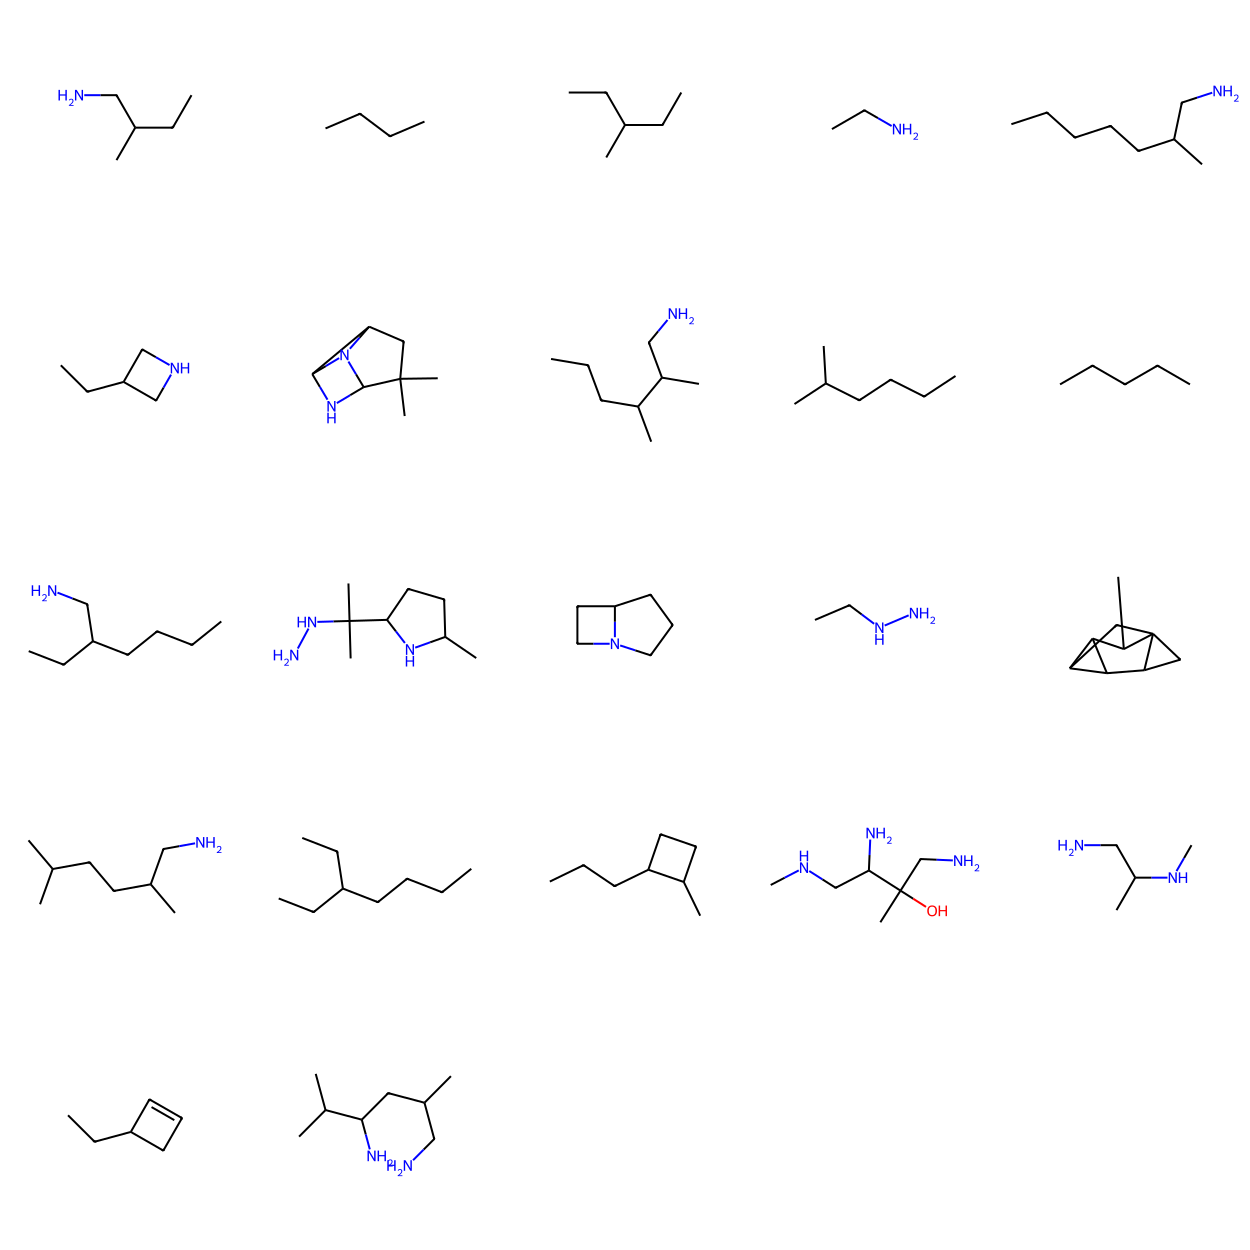

In [ ]:
img